# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Regressão-Linear" data-toc-modified-id="Regressão-Linear-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Regressão Linear</a></div><div class="lev2 toc-item"><a href="#Objetivos" data-toc-modified-id="Objetivos-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Objetivos</a></div><div class="lev2 toc-item"><a href="#Importação-dos-módulos" data-toc-modified-id="Importação-dos-módulos-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Importação dos módulos</a></div><div class="lev2 toc-item"><a href="#Problema-de-Regressão-Linear" data-toc-modified-id="Problema-de-Regressão-Linear-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Problema de Regressão Linear</a></div><div class="lev2 toc-item"><a href="#Conjunto-de-dados:-Flores-Íris" data-toc-modified-id="Conjunto-de-dados:-Flores-Íris-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Conjunto de dados: Flores Íris</a></div><div class="lev2 toc-item"><a href="#Dados:-leitura-e-visualização" data-toc-modified-id="Dados:-leitura-e-visualização-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Dados: leitura e visualização</a></div><div class="lev2 toc-item"><a href="#Visualização-dos-dados-x-e-y" data-toc-modified-id="Visualização-dos-dados-x-e-y-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Visualização dos dados <code>x</code> e <code>y</code></a></div><div class="lev2 toc-item"><a href="#Normalização-dos-dados-entre-0-e-1" data-toc-modified-id="Normalização-dos-dados-entre-0-e-1-17"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Normalização dos dados entre 0 e 1</a></div><div class="lev2 toc-item"><a href="#Visualização-dos-dados-normalizados" data-toc-modified-id="Visualização-dos-dados-normalizados-18"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Visualização dos dados normalizados</a></div><div class="lev2 toc-item"><a href="#Reta-de-ajuste" data-toc-modified-id="Reta-de-ajuste-19"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Reta de ajuste</a></div><div class="lev2 toc-item"><a href="#Representação-gráfica-da-equação-linear-via-neurônio" data-toc-modified-id="Representação-gráfica-da-equação-linear-via-neurônio-110"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>Representação gráfica da equação linear via neurônio</a></div><div class="lev2 toc-item"><a href="#Formulação-matricial" data-toc-modified-id="Formulação-matricial-111"><span class="toc-item-num">1.11&nbsp;&nbsp;</span>Formulação matricial</a></div><div class="lev3 toc-item"><a href="#Formulação-matricial-do-neurônio" data-toc-modified-id="Formulação-matricial-do-neurônio-1111"><span class="toc-item-num">1.11.1&nbsp;&nbsp;</span>Formulação matricial do neurônio</a></div><div class="lev3 toc-item"><a href="#Formulação-matricial-para-implementação-processando-$M$-amostras-simultaneamente" data-toc-modified-id="Formulação-matricial-para-implementação-processando-$M$-amostras-simultaneamente-1112"><span class="toc-item-num">1.11.2&nbsp;&nbsp;</span>Formulação matricial para implementação processando <span class="MathJax_Preview" style="color: inherit;"><span class="MJXp-math" id="MJXp-Span-218"><span class="MJXp-mi MJXp-italic" id="MJXp-Span-219">M</span></span></span><script type="math/tex" id="MathJax-Element-21">M</script> amostras simultaneamente</a></div><div class="lev3 toc-item"><a href="#Multiplicação-Matricial-no-NumPy" data-toc-modified-id="Multiplicação-Matricial-no-NumPy-1113"><span class="toc-item-num">1.11.3&nbsp;&nbsp;</span>Multiplicação Matricial no NumPy</a></div><div class="lev2 toc-item"><a href="#Programação-Matricial" data-toc-modified-id="Programação-Matricial-112"><span class="toc-item-num">1.12&nbsp;&nbsp;</span>Programação Matricial</a></div><div class="lev2 toc-item"><a href="#Formulação-do-problema-do-ajuste-da-reta-como-um-problema-de-minimização" data-toc-modified-id="Formulação-do-problema-do-ajuste-da-reta-como-um-problema-de-minimização-113"><span class="toc-item-num">1.13&nbsp;&nbsp;</span>Formulação do problema do ajuste da reta como um problema de minimização</a></div><div class="lev3 toc-item"><a href="#Função-Custo-ou-de-Perda" data-toc-modified-id="Função-Custo-ou-de-Perda-1131"><span class="toc-item-num">1.13.1&nbsp;&nbsp;</span>Função Custo ou de Perda</a></div><div class="lev3 toc-item"><a href="#compute_cost---formulação-matricial" data-toc-modified-id="compute_cost---formulação-matricial-1132"><span class="toc-item-num">1.13.2&nbsp;&nbsp;</span>compute_cost - formulação matricial</a></div><div class="lev3 toc-item"><a href="#Código-compute_cost" data-toc-modified-id="Código-compute_cost-1133"><span class="toc-item-num">1.13.3&nbsp;&nbsp;</span>Código compute_cost</a></div><div class="lev2 toc-item"><a href="#Minimização-via-Gradiente-Descendente" data-toc-modified-id="Minimização-via-Gradiente-Descendente-114"><span class="toc-item-num">1.14&nbsp;&nbsp;</span>Minimização via Gradiente Descendente</a></div><div class="lev2 toc-item"><a href="#Determinação-do-Gradiente-da-Função-de-Custo" data-toc-modified-id="Determinação-do-Gradiente-da-Função-de-Custo-115"><span class="toc-item-num">1.15&nbsp;&nbsp;</span>Determinação do Gradiente da Função de Custo</a></div><div class="lev3 toc-item"><a href="#Gradiente-para-uma-amostra" data-toc-modified-id="Gradiente-para-uma-amostra-1151"><span class="toc-item-num">1.15.1&nbsp;&nbsp;</span>Gradiente para uma amostra</a></div><div class="lev3 toc-item"><a href="#Gradiente-para-$M$-amostras,-formulação-matricial" data-toc-modified-id="Gradiente-para-$M$-amostras,-formulação-matricial-1152"><span class="toc-item-num">1.15.2&nbsp;&nbsp;</span>Gradiente para <span class="MathJax_Preview" style="color: inherit;"><span class="MJXp-math" id="MJXp-Span-1516"><span class="MJXp-mi MJXp-italic" id="MJXp-Span-1517">M</span></span></span><script type="math/tex" id="MathJax-Element-75">M</script> amostras, formulação matricial</a></div><div class="lev3 toc-item"><a href="#Gradiente-descendente" data-toc-modified-id="Gradiente-descendente-1153"><span class="toc-item-num">1.15.3&nbsp;&nbsp;</span>Gradiente descendente</a></div><div class="lev2 toc-item"><a href="#Laço-de-minimização-via-gradiente-descendente" data-toc-modified-id="Laço-de-minimização-via-gradiente-descendente-116"><span class="toc-item-num">1.16&nbsp;&nbsp;</span>Laço de minimização via gradiente descendente</a></div><div class="lev3 toc-item"><a href="#Gradiente-Descendente-por-Lote-(batch)" data-toc-modified-id="Gradiente-Descendente-por-Lote-(batch)-1161"><span class="toc-item-num">1.16.1&nbsp;&nbsp;</span>Gradiente Descendente por Lote (<em>batch</em>)</a></div><div class="lev3 toc-item"><a href="#Gradiente-Descendente-Estocástico" data-toc-modified-id="Gradiente-Descendente-Estocástico-1162"><span class="toc-item-num">1.16.2&nbsp;&nbsp;</span>Gradiente Descendente Estocástico</a></div><div class="lev3 toc-item"><a href="#Laço-de-minimização-via-gradiente-descendente---Código" data-toc-modified-id="Laço-de-minimização-via-gradiente-descendente---Código-1163"><span class="toc-item-num">1.16.3&nbsp;&nbsp;</span>Laço de minimização via gradiente descendente - Código</a></div><div class="lev3 toc-item"><a href="#Plot-da-curva-de-minimização-de-J-com-o-número-de-iterações" data-toc-modified-id="Plot-da-curva-de-minimização-de-J-com-o-número-de-iterações-1164"><span class="toc-item-num">1.16.4&nbsp;&nbsp;</span>Plot da curva de minimização de J com o número de iterações</a></div><div class="lev2 toc-item"><a href="#Comparando-com-a-solução-analítica" data-toc-modified-id="Comparando-com-a-solução-analítica-117"><span class="toc-item-num">1.17&nbsp;&nbsp;</span>Comparando com a solução analítica</a></div><div class="lev2 toc-item"><a href="#Plotagem-da-reta-de-predição-(solução-analítica-e-solução-via-gradiente-descendente)" data-toc-modified-id="Plotagem-da-reta-de-predição-(solução-analítica-e-solução-via-gradiente-descendente)-118"><span class="toc-item-num">1.18&nbsp;&nbsp;</span>Plotagem da reta de predição (solução analítica e solução via gradiente descendente)</a></div><div class="lev2 toc-item"><a href="#Plotagem-das-retas-durante-o-processo-de-minimização" data-toc-modified-id="Plotagem-das-retas-durante-o-processo-de-minimização-119"><span class="toc-item-num">1.19&nbsp;&nbsp;</span>Plotagem das retas durante o processo de minimização</a></div><div class="lev2 toc-item"><a href="#Visualização-do-espaço-de-parâmetros" data-toc-modified-id="Visualização-do-espaço-de-parâmetros-120"><span class="toc-item-num">1.20&nbsp;&nbsp;</span>Visualização do espaço de parâmetros</a></div><div class="lev2 toc-item"><a href="#Visualização-da-Perda-x-Parâmetros-w0,w1-em-gráfico-3D" data-toc-modified-id="Visualização-da-Perda-x-Parâmetros-w0,w1-em-gráfico-3D-121"><span class="toc-item-num">1.21&nbsp;&nbsp;</span>Visualização da Perda x Parâmetros w0,w1 em gráfico 3D</a></div><div class="lev2 toc-item"><a href="#Regressão-Linear-no-Keras" data-toc-modified-id="Regressão-Linear-no-Keras-122"><span class="toc-item-num">1.22&nbsp;&nbsp;</span>Regressão Linear no Keras</a></div><div class="lev3 toc-item"><a href="#Regressão-linear-como-uma-camada-de-um-neurônio-e-ativação-linear" data-toc-modified-id="Regressão-linear-como-uma-camada-de-um-neurônio-e-ativação-linear-1221"><span class="toc-item-num">1.22.1&nbsp;&nbsp;</span>Regressão linear como uma camada de um neurônio e ativação linear</a></div><div class="lev3 toc-item"><a href="#Modelo-Sequencial" data-toc-modified-id="Modelo-Sequencial-1222"><span class="toc-item-num">1.22.2&nbsp;&nbsp;</span>Modelo Sequencial</a></div><div class="lev3 toc-item"><a href="#Configurando-método-de-otimização-e-compilando-código-para-o-treinamento" data-toc-modified-id="Configurando-método-de-otimização-e-compilando-código-para-o-treinamento-1223"><span class="toc-item-num">1.22.3&nbsp;&nbsp;</span>Configurando método de otimização e compilando código para o treinamento</a></div><div class="lev3 toc-item"><a href="#Treinamento---batch-gradient-descent" data-toc-modified-id="Treinamento---batch-gradient-descent-1224"><span class="toc-item-num">1.22.4&nbsp;&nbsp;</span>Treinamento - batch gradient descent</a></div><div class="lev2 toc-item"><a href="#Sugestões-de-atividades" data-toc-modified-id="Sugestões-de-atividades-123"><span class="toc-item-num">1.23&nbsp;&nbsp;</span>Sugestões de atividades</a></div><div class="lev2 toc-item"><a href="#Exercícios-de-programação" data-toc-modified-id="Exercícios-de-programação-124"><span class="toc-item-num">1.24&nbsp;&nbsp;</span>Exercícios de programação</a></div><div class="lev2 toc-item"><a href="#Conclusões-desse-experimento" data-toc-modified-id="Conclusões-desse-experimento-125"><span class="toc-item-num">1.25&nbsp;&nbsp;</span>Conclusões desse experimento</a></div><div class="lev2 toc-item"><a href="#Referências" data-toc-modified-id="Referências-126"><span class="toc-item-num">1.26&nbsp;&nbsp;</span>Referências</a></div>

# Regressão Linear

## Objetivos

Os objetivos deste notebook são:

* introduzir os conceitos básicos iniciais de redes neurais através da 
* otimização de um ajuste de pontos por uma reta (linear) utilizando a 
* técnica de cálculo numérico do gradiente descendente. 

É introduzido também:

* o uso de matrizes tanto como 
    * notação matemática como 
    * forma de programação. 

Este notebook contém:
* primeiros programas matriciais de redes neurais, 
* laço de otimização e 
* plotagem de gráficos.
* Primeiro programa em Keras


## Importação dos módulos

O objetivo deste exercício é utilizar apenas as funções do NumPy para o processamento numérico. Iremos precisar entretanto de dois outros pacotes para:

* NumPy: Pacote Numérico do Python - é o que faz o Python ser melhor que o MATLAB
* matplotlib: ferramentas para plotagem de gráficos e imagens
* sklearn: Excelente pacote de "Aprendizagem de Máquina", aqui será usado apenas para carregar o dataset Iris
* pandas: ferramentas de formatação e visualização de dados em forma de tabelas

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

## Problema de Regressão Linear

O problema de ajuste de uma reta a um conjunto de pontos para verificar se existe uma previsão linear é um problema muito antigo, muito estudado e muito presente nos dias de hoje. 

Quando o ajuste é abordado como um problema de **otimização numérica**, ele é a base de boa parte dos **conceitos sobre redes neurais** e iremos explorá-lo aqui como uma forma de introdução às redes neurais. O modelo de regressão linear que iremos utilizar pode
ser visto como uma rede neural de apenas uma camada e função de ativação linear.

## Conjunto de dados: Flores Íris

Iremos utilizar duas propriedades do conjunto de dados das flores Íris [Wikipedia-Iris_flower_data_set](https://en.wikipedia.org/wiki/Iris_flower_data_set):

* o comprimento das sépalas e 
* o comprimento da pétalas. 

A ideia será prever o comprimento da pétala, conhecendo-se o comprimento da sépala. Estaremos usando apenas uma propriedade, ou característica ou *feature* do objeto para que seja fácil visualizar o espaço de busca de parâmetros. 

Vamos utilizar as 50 amostras da variedade versicolor.

![](../figures/iris_petals_sepals.png)

## Dados: leitura e visualização

O carregamento dos dados é feito pelo comando do pacote sklearn: `load_iris`.

In [2]:
iris = load_iris()
print(type(iris))
print('iris.data:',iris.data.shape,iris.data.dtype,iris.data.min(),iris.data.max())
print('iris.target:',iris.target.shape,iris.target.dtype,iris.target.min(),iris.target.max())
#print(iris.DESCR)
print('iris.features_name:',iris.feature_names)
print('iris.target_names:',iris.target_names)

iris_pd = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_pd['target'] = iris.target
iris_pd


<class 'sklearn.datasets.base.Bunch'>
iris.data: (150, 4) float64 0.1 7.9
iris.target: (150,) int64 0 2
iris.features_name: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
iris.target_names: ['setosa' 'versicolor' 'virginica']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


 Iremos utilizar apenas duas informações da variedade versicolor (classe 1): 

* x: comprimento das sépalas,
* y: comprimento das pétalas.

Imprimimos o *shape* dos *arrays* `x` e `y`. O *shape* indica as dimensões do array. Neste caso, observe que possui apenas uma dimensão com 50 elementos cada. 

`x` e `y` são portanto dois arrays unidimensionais com 50 elementos cada, que são o número de amostras da variedade versicolor.

Imprimimos também, a título ilustrativo estes dois vetores:

In [3]:
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x = data[:,0:1]
y = data[:,1:2]

print('x.shape:',x.shape, x.dtype)
print('y.shape:',y.shape, y.dtype)

print('x[:5]:\n', x[:5])
print('y[:5]:\n', y[:5])

x.shape: (50, 1) float64
y.shape: (50, 1) float64
x[:5]:
 [[ 7. ]
 [ 6.4]
 [ 6.9]
 [ 5.5]
 [ 6.5]]
y[:5]:
 [[ 4.7]
 [ 4.5]
 [ 4.9]
 [ 4. ]
 [ 4.6]]


## Visualização dos dados `x` e `y`

A visualização das amostras é feita com o matplotlib, neste caso utilizando o `scatter`:

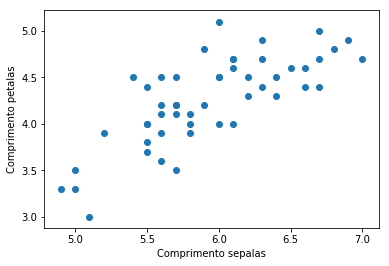

In [4]:
plt.scatter(x, y)
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')
plt.show()

## Normalização dos dados entre 0 e 1

A equação da normalização dos dados para que o resultado fique entre 0 e 1 é:

$$ y = \frac{x - x_{min}}{x_{max}-x_{min}} $$

Uma forma usual sequencial de fazer esta operação de forma um pouco mais eficiente é:

$$ xx = x - x_{min} \\
   y = \frac{xx}{xx_{max}} $$

Desta forma é usual implementar a normalização através de uma subtração *in place* do mínimo e depois uma divisão também *in place* pelo máximo:

In [5]:
x -= x.min()
x /= x.max()    # normalização
y -= y.min()
y /= y.max()

#y = 2*x        # útil para verificar se o programa está funcionando (como exercício)

## Visualização dos dados normalizados


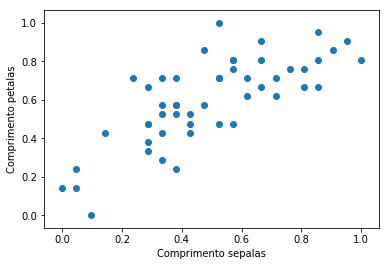

In [6]:
plt.scatter(x, y)
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')
plt.show()

## Reta de ajuste

A equação da reta no plano necessita de dois parâmetros, aqui denominados $w_0$ (*bias*) e inclinação $w_1$. Veja figura:


<img src="../figures/linhareta.png", width=300pt>

A reta de ajuste será dada por:

$$ \hat{y} = w_0 + w_1 x $$

onde 
* $w_1$ é o coeficiente angular da reta e 
* $w_0$ é a interseção do eixo vertical quando x é igual a zero, também denominado de *bias*.
* $x$ é a variável de entrada (comprimento das sépalas) e 
* $\hat{y}$ é a predição (comprimento estimado das pétalas).

## Representação gráfica da equação linear via neurônio

$ \hat{y} = 1 w_0 + x_0 w_1 $

Temos:
- 1 atributo de entrada: $x_0$
- 2 parâmetros para serem ajustados (treinados) $w_0$ e $w_1$
- 1 classe de saída $\hat{y}$

<img src="../figures/RegressaoLinearNeuronio.png", width=300pt>

$$ \mathbf{\hat{y}} = \mathbf{w} \mathbf{x} $$

## Formulação matricial

As redes neurais em geral, são formadas por muitas entradas, várias saídas e vários parâmetros. A melhor forma de se
representar matematicamente as redes neurais são através de matrizes. Apesar desse problema ter apenas uma entrada,
uma saída e dois parâmetros de ajustes, iremos representar na forma matricial, para que a formulação possa ser generalizada para
várias entradas e várias saídas (e várias camadas).

Em notação matricial, iremos usar a convenção de representar vetores em negritos e letras minúsculas,
enquanto que matrizes iremos representar por letras maiúsculas em negrito.

Existem dois casos de formulação matricial: 1) para representar os neurônios na rede neural; 2) utilizado no processamento de várias amostras simultaneamente. Segue a descrição para cada um dos casos:

### Formulação matricial do neurônio

* $\mathbf{w} = [w_0 w_1]$ é vetor linha de parâmetros e 
* $\mathbf{x} = \begin{bmatrix} 1 \\ x_0 \end{bmatrix} $ é vetor coluna de uma amostra (com *bias*).

$$ \hat{y} = 1 w_0 + x_0 w_1 $$

$$ [\hat{y}] = [w_0 \ w_1] \begin{bmatrix} 1 \\ x_0 \end{bmatrix} $$

$$ \mathbf{\hat{y}} = \mathbf{w} \mathbf{x} $$

### Formulação matricial para implementação processando $M$ amostras simultaneamente

Quando temos $M$ amostras, a forma padronizada de organizar os dados de entrada é transpor as informações de cada amostra colocando-a em cada linha da
matriz $\mathbf{X}$:

$$ \mathbf{X} = \begin{bmatrix}
1 & x_0 \\ 
1 & x_1\\
\vdots & \vdots \\ 
1 & x_{M-1}
\end{bmatrix} $$

Desta forma, pode-se calcular o $\hat{y}$ de todas as amostras por:

$$ \begin{matrix} 
\begin{bmatrix}
\hat{y}_0\\ 
\hat{y}_1\\
\\
\hat{y}_{M-1} 
\end{bmatrix} &=& \begin{bmatrix}
1 & x_0 \\ 
1 & x_1\\
\\ 
1 & x_{M-1} \\ 
\end{bmatrix}
&
\begin{bmatrix}
w_0\\ 
w_1
\end{bmatrix} \\
(M,1) & & (M,2) & (2,1) \\
\end{matrix} $$

Na forma matricial:

$$ \mathbf{\hat{y}} = \mathbf{X} \mathbf{w}^T $$

### Multiplicação Matricial no NumPy

A multiplicação entre matrizes e entre matriz e vetor é implementada em 
Python/Numpy usando o operador `dot`. 
Temos duas notações principais:  
* `X.dot(w)` ou 
* `np.dot(X,w)`. 

As matrizes são caracterizadas pelas suas dimensões que no NumPy são denominados
* `shape` que para matrizes é organizado em 
* `(linhas, colunas)`. 

Na multiplicação $\mathbf{X} \mathbf{w}^T$, 
* `X.shape=(M,2)` e 
* `wT.shape=(2,1)`, cujo resultado da multiplicação será 
* `(M,2)(2,1)->(M,1)` que é shape do vetor columa $\mathbf{\hat{y}}$.

**Dica:** Operações matriciais tornam o código conciso, escalável e simples, porém, é comum aparecer erros nestas operações e uma das melhores formas de se depurar um programa matricial é verificando
as dimensões (*shape*) das matrizes e vetores em uso.

## Programação Matricial

Como iremos trabalhar com várias amostras, vários parâmetros, várias características e várias classes, é mais eficiente trabalhar com vetores, matrizes e *arrays* por ser uma forma muito mais eficiente de se programar e de se processar. 

Talvez essa seja uma das **principais dificuldades** de programadores de linguagens "estilo C" onde é usual o uso de laços explícitos nos cálculos. 

Neste curso iremos usar o NumPy que é o pacote de *arrays* numéricos que permitem programação matricial de forma muito eficiente.

## Formulação do problema do ajuste da reta como um problema de minimização

Dado um conjunto de $m$ pontos **rotulados** $(x_i,y_i)$ (conjunto de treinamento), 
queremos encontrar uma equação linear de predição do valor de $y$ dado um $x$ desconhecido. 
A equação da predição $\hat{y}$, na forma:

* $ \hat{y} = w_0 + w_1\ x $ 

deve ter seus parâmetros $w_0$ e $w_1$ escolhidos de modo que o erro médio quadrático

* $ \sum (\hat{y_i} - y_i)^2 $ entre as estimativas e o valor das amostras $i$ seja mínimo. 

### Função Custo ou de Perda

A função de custo depende do conjunto de treinamento ($y_i$) e dos valores de predição ($\hat{y_i}$):

$$ J(\hat{y_i},y_i) = \frac{1}{M} \sum_{i=0}^{M-1} (\hat{y_i} - y_i)^2 $$ .

Trocando $\hat{y_i}$ pelo valor da predição, a função de custo depende das amostras de treinamento $x_i, y_i$ e 
do parâmetro de predição $w_i$:

$$ J(x_i,y_i,w_i) = \frac{1}{M} \sum_{i=0}^{M-1} ((w_0 + w_1\ x_i) - y_i)^2 $$ 

Buscamos encontrar os valores de $w_i$ para que $J(x_i,y_i,w_i)$ seja mínimo no conjunto de treinamento ($x_i, y_i$).

Em notação matricial, o cálculo do custo para $M$ amostras fica:

$$ \mathbf{e} = \hat{\mathbf{y}} - \mathbf{y} = \mathbf{X} \mathbf{w}^T - \mathbf{y} $$

$$ J(\mathbf{w}) = \frac{1}{M} \left \Vert \mathbf{e} \right \|^2 $$

onde $\left \Vert \textbf{e} \right \|^2$ é a norma do vetor $\textbf{e}$ ao quadrado, dado por:
$\left \Vert \textbf{e} \right \|^2 = \sum_{i}{\textbf{e}_i}^2$

A seguir é mostrado uma implementação matricial desta função:


### compute_cost - formulação matricial

Caso de apenas um $w^T = \begin{bmatrix} w_0 \\ w_1\end{bmatrix}$ com shape(2,1):

$$ \begin{matrix}
e &=& \begin{bmatrix}
1 & x_0 \\ 
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_{M-1}
\end{bmatrix} &
\begin{bmatrix}
w_0\\ 
w_1
\end{bmatrix} &-& \begin{bmatrix}
y_0\\ 
y_1\\ 
\vdots\\ 
y_{M-1}\\ 
\end{bmatrix} &=& \begin{bmatrix}
e_0\\ 
e_1\\ 
\vdots\\ 
e_{M-1}\\ 
\end{bmatrix}\\
& & (M,2) & (2,1) & & (M,1) & & (M,1)
 \end{matrix} $$ 

$$ J = \frac{1}{M}\sum_{i=0}^{M-1} e_i^2 $$

Caso com vários $w$ na forma matricial com shape(2,n_history):

$$ \begin{matrix}
e &=& \begin{bmatrix}
1 & x_0 \\ 
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_{M-1}
\end{bmatrix} &
\begin{bmatrix}
w_{0,0} & w_{0,1} & \ldots & w_{0,P-1}\\ 
w_{1,0} & w_{1,1} & \ldots & w_{1,P-1} 
\end{bmatrix} &-& \begin{bmatrix}
y_0\\ 
y_1\\ 
\vdots\\ 
y_{M-1}\\ 
\end{bmatrix} &=& \begin{bmatrix}
e_{0,0} & e_{0,1} & \ldots & e_{0,P-1}\\ 
e_{1,0} & e_{1,1} & \ldots & e_{1,P-1}\\ 
\vdots\\ 
e_{M-1,0} & e_{M-1,1} & \ldots & e_{M-1,P-1} 
\end{bmatrix}\\
& & (M,2) & (2,P) & & (M,1) & & (M,P)
 \end{matrix} $$ 

$$ J = \begin{bmatrix} \frac{1}{M}\sum_{i=0}^{M-1} e_{i,0}^2 & \frac{1}{M}\sum_{i=0}^{M-1} e_{i,1}^2 & \ldots & \frac{1}{M}\sum_{i=0}^{M-1} e_{i,P-1}^2 \end{bmatrix} $$

### Código compute_cost

In [7]:
def compute_cost(X_b, y, wT):
    '''
    Compute cost for linear regression
    (X,y): amostras rotuladas X(n_samples,2) e y(n_samples,)
    wT: vetor coluna de parâmetros (já transposto)
       aceita tanto shape (2,1) Para um caso como (2,n_history) para n_history casos
    '''
    e = X_b.dot(wT) - y
    J = (e * e).mean(axis=0)
    return J

## Minimização via Gradiente Descendente

O problema então se resume em encontrar os coeficientes de $\mathbf{w}$ que minimizem $J(\mathbf{w})$ no conjunto de dados rotulados `(X,y)`. Existem várias formas de se realizar esta otimização. Para fazer uma analogia com as redes neurais, a otimização será obtida por método de cálculo numérico
conhecido como "gradiente descendente". Como o gradiente de uma função aponta sempre para os valores mais altos da função, o método do gradiente descendente consiste em atualizar o valor de $\mathbf{w}$ subtraindo-o proporcionalmente do gradiente, isto é, indo na direção contrária do gradiente na expectativa de que iremos encontrar valores menores.

## Determinação do Gradiente da Função de Custo

O gradiente da função Custo ($\mathbf{\nabla{J_w}}$) para este caso onde 
$\mathbf{w}=\begin{bmatrix}w_0 & w_1\end{bmatrix}$ é um vetor de derivadas partiais:

$$ \mathbf{\nabla{J_w}} = \begin{bmatrix} \frac{\partial J}{\partial w_0} & \frac{\partial J}{\partial w_1}\end{bmatrix} $$

### Gradiente para uma amostra

Vamos inicialmente calcular o gradiente para uma única amostra e depois iremos generalizar para $M$ amostras. O custo para uma amostra é dado por:

$$ J = (\hat{y} - y)^2 = (\begin{bmatrix} w_0 & w_1 \end{bmatrix}\begin{bmatrix} x_0 \\ x_1 \end{bmatrix}  - y)^2
     = (\mathbf{wx} - y)^2$$
     
$$ J = (w_0 x_0 + w_1 x_1 - y)^2 $$

$$ \frac{\partial J}{\partial w_0} = 2 x_0 (w_0 x_0 + w_1 x_1 - y) = 2 x_0 (\mathbf{wx} - y)$$
$$ \frac{\partial J}{\partial w_1} = 2 x_1 (w_0 x_0 + w_1 x_1 - y) = 2 x_1 (\mathbf{wx} - y)$$

$$\begin{bmatrix} \frac{\partial J}{\partial w_0} & \frac{\partial J}{\partial w_1}\end{bmatrix} =
\begin{bmatrix} 2 x_0 (\mathbf{wx} - y) & 2 x_1 (\mathbf{wx} - y)\end{bmatrix} = 2(\mathbf{wx} - y)\mathbf{x}^T
$$
Assim, o gradiente para uma amostra é dado por:
$$ \mathbf{\nabla{J_w}} = 2(\mathbf{wx} - y)\mathbf{x}^T $$

### Gradiente para $M$ amostras, formulação matricial

Vimos anteriormente que quando processamos com várias amostras simultaneamente, utilizamos a matrix $\mathbf{X}$
onde cada linha se refere a uma amostra transposta: ($\mathbf{x}^T$):

$$ \mathbf{X} = \begin{bmatrix}
\longleftarrow & (\mathbf{x}^{(0)})^T & \longrightarrow \\ 
\longleftarrow & (\mathbf{x}^{(1)})^T & \longrightarrow \\ 
  & \vdots  & \\ 
\longleftarrow & (\mathbf{x}^{(M-1)})^T & \longrightarrow 
\end{bmatrix} = \begin{bmatrix}
x_{0,0} & x_{0,1} \\
x_{1,0} & x_{1,1} \\
\vdots  & \vdots  \\ 
x_{M,0} & x_{M,1} \\
\end{bmatrix} $$

Assim, é preciso tirar a transposta da equação do gradiente para uma amostra, trocando o vetor 
$\mathbf{x}^T$ por $\mathbf{X}$ e o escalar $y$ por um vetor $\mathbf{y}^T$:

$$  (\mathbf{\nabla{J_w}})^T = \frac{2}{M}((\mathbf{wX^T} - \mathbf{y}^T)\mathbf{X})^T $$, resultando
$$  (\mathbf{\nabla{J_w}})^T = \frac{2}{M}\mathbf{X}^T(\mathbf{Xw^T} - \mathbf{y}) $$.


### Gradiente descendente

Na equação da atualização do $\mathbf{w}$ a seguir, o fator $\eta$ é denominado *learning rate*. Ele é um parâmetro de ajuste fundamental para o sucesso da otimização: 

$$ \mathbf{w}^T = \mathbf{w}^T − \eta (\mathbf{\nabla J_w})^T $$

Desta forma então, calculando-se o gradiente de $J(\mathbf{w})$ e substituindo na equação acima temos:

$$ \mathbf{w}^T = \mathbf{w}^T − \eta \frac{2}{M}(\mathbf{X}^T(\mathbf{X}\mathbf{w}^T−\mathbf{y})) $$

Esta equação é implementada dentro da função `gradient_descent`.

Observe que cada atualização dos pesos, o cálculo do gradiente leva em conta todas as amostras
de dados que estão representados na matriz $\mathbf{X}$ que possui $M$ linhas (amostras).

## Laço de minimização via gradiente descendente

O código da próxima célula é a parte principal deste notebook. É aqui que a minimização é feita. É aqui que dizemos que estamos fazendo o *fit*, ou o treinamento do sistema para encontrar o parâmetro $\mathbf{W}$ que minimiza a função de perda $J$. Acompanhamos a convergência da minimização pelo valor da perda a cada iteração, plotando o vetor `J_history`.


O esquema da otimização é representado pelo diagrama a seguir:

<img src="../figures/RegressaoLinear_Otimizacao.png",width = 600pt>

e é implementado pela próxima célula de código:

### Gradiente Descendente por Lote (*batch*)

In [8]:
def batch_gradient_descent(X, y, w_init, lr, n_epochs):
    '''
    Perform batch gradient descent to learn w
    by taking n_epochs gradient steps with learning
    rate lr
    Dados rotulados: X.shape:(M,2) e y.shape:(M,1)
    Parâmetro inicial: w_init.shape:(1,2)
    output: w_history:(num_epochs+1,2)
    '''
    M = y.size
    w_history = np.zeros((2,n_epochs+1))
    wT = w_init.T
    w_history[:,0] = wT[:,0]

    for i in range(n_epochs):
        wT = wT - lr * (2.0 / M) * (X.T).dot(X.dot(wT) - y)
        w_history[:,i+1]=wT[:,0]
    return w_history.T

### Gradiente Descendente Estocástico

In [9]:
def stochastic_gradient_descent(X, y, w_init, lr, n_epochs):
    '''
    Perform stochastic gradient descent to learn w
    by taking n_epochs times number of samples 
    gradient steps with learning rate lr
    Dados rotulados: X.shape:(M,2) e y.shape:(M,1)
    Parâmetro inicial: w_init.shape:(1,2)
    output: w_history:(num_epochs+1,2)
    '''
    M = y.size
    w_history = np.zeros((2,(M*n_epochs)+1))
    wT = w_init.T
    w_history[:,0] = wT[:,0]

    for i in range(n_epochs):
        for jj in range(M):
            j = np.random.randint(M)
            wT = wT - lr * 2.0 * (X[j:j+1,:].T).dot(X[j:j+1,:].dot(wT) - y[j:j+1])
            w_history[:,jj+(i*M)+1] = wT[:,0]
    return w_history.T

### Laço de minimização via gradiente descendente - Código

In [10]:
# Parâmetros do gradiente descendente: número de iterações e taxa de aprendizagem
iterations = 100
lr = 0.1

n_samples = y.shape[0]

#Montagem da matriz X agora com os elementos 1 na primeira coluna
X_bias = np.hstack([np.ones(shape=(n_samples,1)), x])
w_init = np.zeros(shape=(1,2))

w_history = batch_gradient_descent(X_bias, y, w_init, lr, iterations)
#print(w_history)

w_gd = w_history[::-1][0:1] # pega o último valor do gradiente descendente
print('w_gd:\n', w_gd)
print('final cost (gradiente descendente):', compute_cost(X_bias, y, w_gd.T))

J_history = compute_cost(X_bias, y, w_history.T)
print(J_history[:10])

w_gd:
 [[ 0.34857359  0.51798724]]
final cost (gradiente descendente): [ 0.02286703]
[ 0.40907029  0.24348202  0.1505187   0.09829049  0.0689112   0.05234888
  0.04297685  0.03763921  0.03456589  0.03276406]


### Plot da curva de minimização de J com o número de iterações

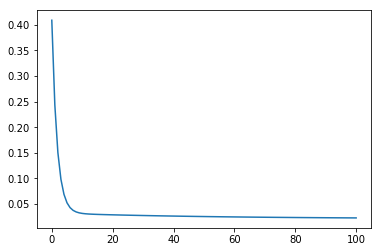

In [11]:
plt.plot(J_history) # mostrando log para amplificar valores baixos
#plt.ylim(0,1)
plt.show()

## Comparando com a solução analítica

A solução analítica deste problema é dada por:

$$  \mathbf{w} =(\mathbf{X}^T \mathbf{X})^{−1}\mathbf{X}^T \mathbf{y} $$

In [12]:
w_opt = (np.linalg.inv((X_bias.T).dot(X_bias)).dot(X_bias.T)).dot(y)
print(w_opt)
print('final cost (analítica):', compute_cost(X_bias, y, w_opt))

[[ 0.26134159]
 [ 0.68646976]]
final cost (analítica): [ 0.02116942]


## Plotagem da reta de predição (solução analítica e solução via gradiente descendente)

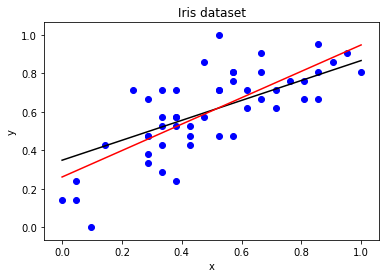

In [13]:
plt.scatter(x, y, marker='o', c='b')
plt.title('Iris dataset')
plt.xlabel('x')
plt.ylabel('y')

# Plotagem da reta utilizando os parâmetros ótimos encontrados no gradiente descendente

X_all = np.linspace(x.min(),x.max(),100).reshape(100,1)
X_all_bias = np.hstack([np.ones((100,1)),X_all])
result = X_all_bias.dot(w_gd.T)  # Predição via minimização gradiente descendente
plt.plot(X_all, result, c='k')
result_opt = X_all_bias.dot(w_opt)  # Predição do valor analítico
plt.plot(X_all, result_opt,c='r')
plt.show()

## Plotagem das retas durante o processo de minimização

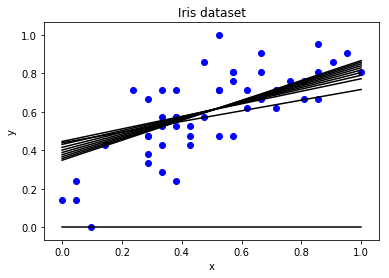

In [14]:
# Plotagem dos pontos
plt.scatter(x, y, marker='o', c='b')
plt.title('Iris dataset')
plt.xlabel('x')
plt.ylabel('y')

for w in w_history[::iterations//10,:]: # 10 parâmetros durante minimização
    result = X_all_bias.dot(w.T)  # Predição
    plt.plot(X_all, result, c='k')
plt.show();

## Visualização do espaço de parâmetros

Como o problema de ajuste de uma reta em pontos bidimensionais precisam da sintonia ou treinamento ou otimização de apenas dois parâmetros: $w_0$ e $w_1$, é possível visualizar o espaço de parâmetros em um gráfico. O trecho a seguir calcula o custo $J(\mathbf{W})$ a ser minimizado. Neste caso, a função $J$ é uma função convexa e possui apenas um único mínimo que será buscado pela técnica do gradiente descendente. O objetivo do gráfico a seguir é poder visualizar a convergência dos parâmetros $\mathbf{W}$ durante o processo de treinamento.

No código abaixo, primeiro é preciso calcular todos os possível $\mathbf{W}$ e para eles calcular a função $J(\mathbf{W})$. Isto é feito de forma matricial, sem a necessidade
de laços explícitos.

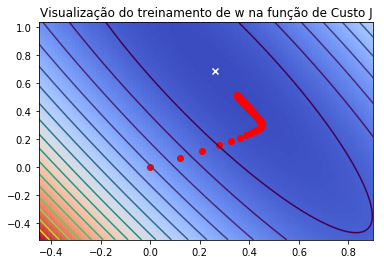

In [15]:
from Jview import Jview

Jview(X_bias, y, w_history, w_opt)

## Visualização da Perda x Parâmetros w0,w1 em gráfico 3D

A trecho a seguir permite a visualização da imagem anterior, agora numa superfície tridimensional de modo que para cada par de parâmetro $(w_0,w_1)$ o valor da perda $J(\mathbf{w})$ é uma altura da superfície no gráfico.
Sobre esta superfície da função Perda, os valores de $\mathbf{w}$ ocorridos durante a busca do
gradiente descendente é mostrado na forma de bolinhas vermelhas. Desta forma é possível acompanhar o caminho que a solução percorre até chegar à solução ótima.

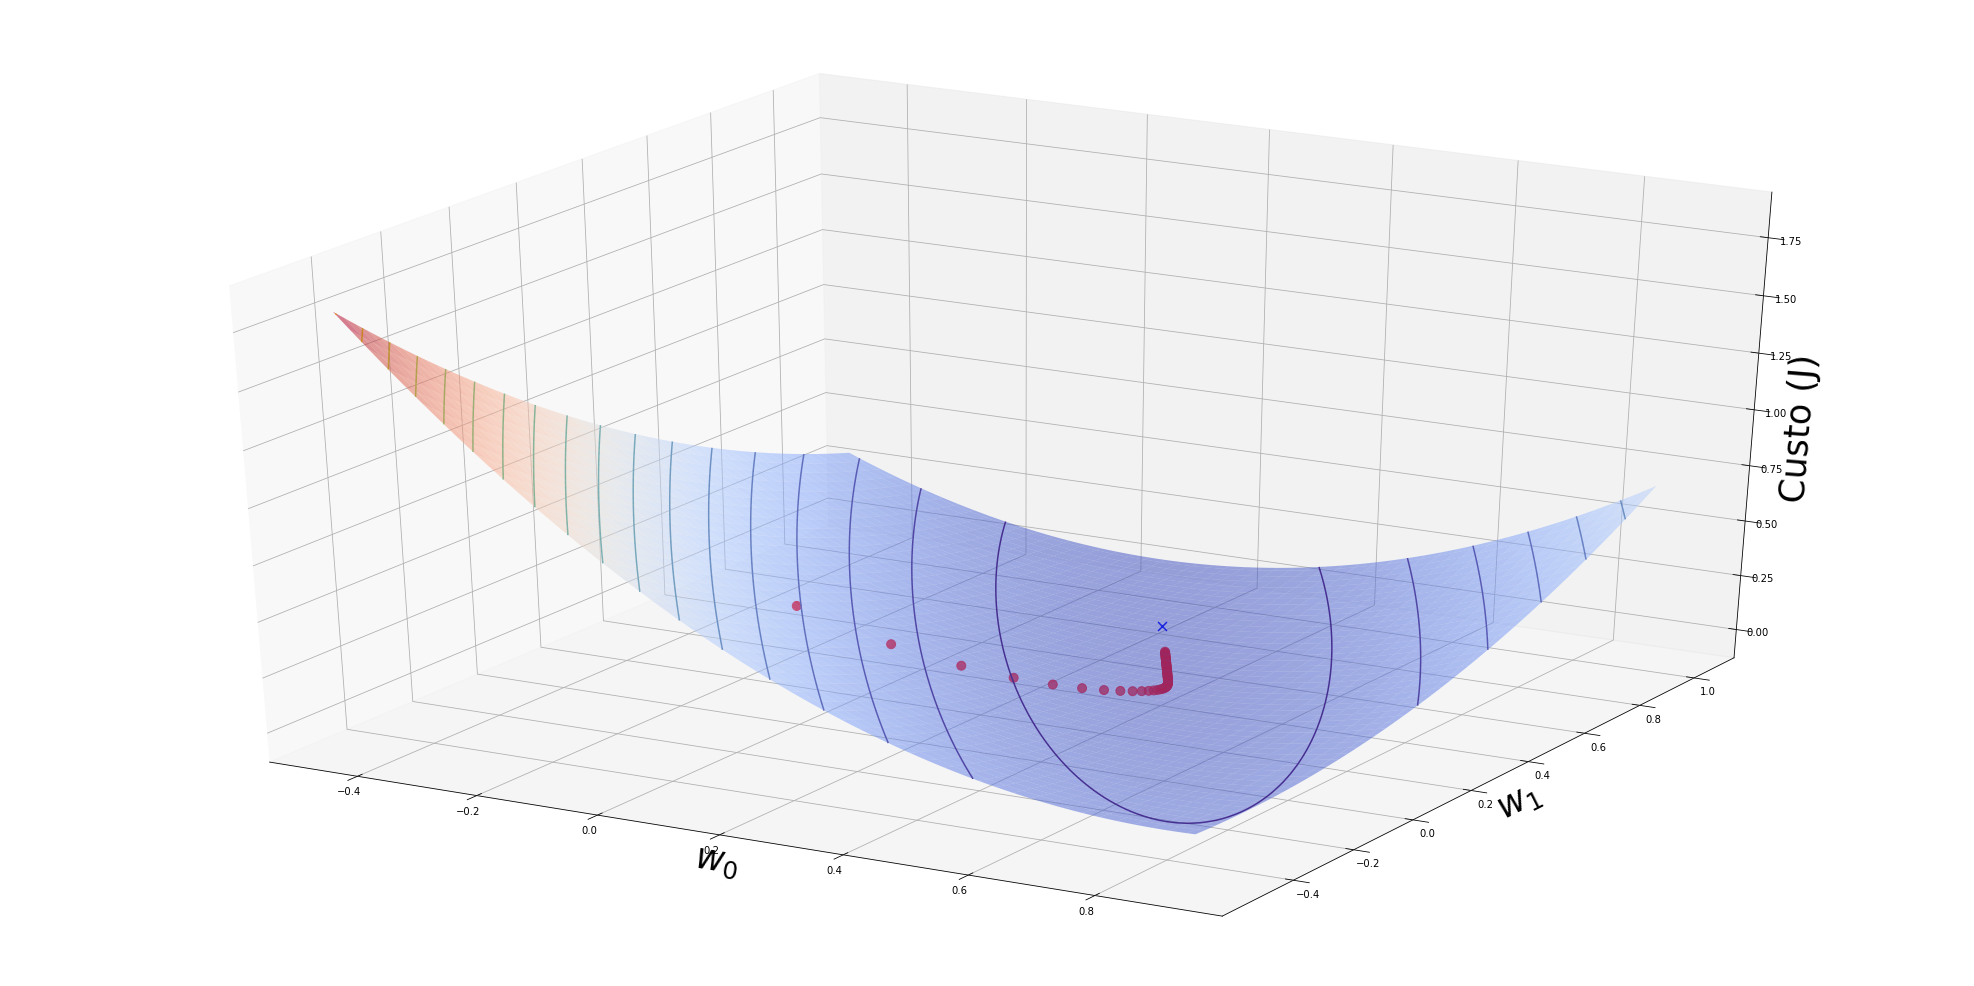

In [16]:
from Jview import Jview3D

Jview3D(X_bias, y, w_history, w_opt)

## Regressão Linear no Keras

In [17]:
import keras
from keras.utils import np_utils 
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras.optimizers import SGD

print(keras.__version__)


Using TensorFlow backend.


2.0.3


### Regressão linear como uma camada de um neurônio e ativação linear

A regressão linear pode ser vista como uma rede neural de uma camada e ativação linear (identidade). Assim, é possível implementar a regressão linear no Keras.

<img src='../figures/RegressaoLinearNeuronioAtivacao.png', width=500pt>

### Modelo Sequencial

A estrutura básica do Keras é o modelo (*model*), a forma mais simples de organizar as camadas da rede neural - apenas uma sequência de camadas. Neste caso será
apenas uma camada básica de rede neural (*Dense*) com uma entrada e apenas uma saída (*units*).

In [18]:
model = Sequential() 
model.add(Dense(units=1, input_dim=1, activation='linear',kernel_initializer="zero")) 


### Configurando método de otimização e compilando código para o treinamento

O Keras utilizada a linguagem TensorFlow ou Theano como *backend*. Ambas linguagens são executadas na forma de fluxo. A função
anterior criou o modelo da rede, agora é necessário configurar o otimizador e compilar o modelo para deixá-lo pronto para o
treinamento. O otimizador é o *SGD - Stochastic Gradient Descent*, que quando o tamanho do *batch* for igual ao número de
amostras, o SGD fica equivalente ao *batch gradiente descent*.

In [19]:
sgd = SGD(lr=0.1)
model.compile(optimizer=sgd, loss='mse') 

### Treinamento - batch gradient descent

Uma vez que o modelo foi compilado com o otimizador, o treinamento é feito pelo *fit*, passando os dados de treinamento, número de épocas e o tamanho do batch:

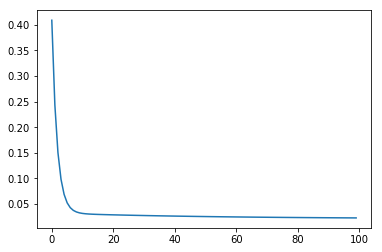

In [20]:
batch_size = 50
nb_epoch = 100
n = x.shape[0] # number of training examples

history = model.fit(x, y, batch_size=batch_size, epochs=nb_epoch,verbose=0)

#print(history.history["loss"][:10])
plt.plot(history.history["loss"]) # mostrando log para amplificar valores baixos
#plt.ylim(0,0.1) # escala máximo y no gráfico 
plt.show()

**Atenção:** Se a célula acima de treinamento for executada novamente, ela continua com o valor do parâmetro já otimizado de sua última execução. Para que o treinamento comece novamente, é preciso executar a inicialização dos parâmetros que ocorre na definição da camada densa.

In [21]:
loss = model.evaluate(x, y, verbose=0)
print('Final loss:',loss)

W = model.get_weights()
print('Bias:\n', W[1])
print('W:\n', W[0])

Final loss: 0.022867026329
Bias:
 [ 0.3485736]
W:
 [[ 0.51798731]]


## Sugestões de atividades

1. Experimente trocar o número de iterações para bem pouco, 10 iterações e ir aumentando aos poucos. Mostre a perda com o número de iterações. Se for necessário, troque o `ylim` do gráfico para melhor visualização da curva da perda.
2. Troque o valor de $Y$ para gerar as amostras de forma sintética como uma reta, por exemplo, `Y = 2*X`. Qual é o valor ótimo que deve ser encontrado. Veja o que acontece e se o valor converge para o valor ótimo.
3. Varie a taxa de aprendizagem e verifique qual é o valor máximo e mínimo que pode ser utilizado.
4. Retire a normalização que é feita logo após a leitura dos dados e verifique o que acontece.
5. Troque a função do gradiente descendente, em vez de usar a `batch_gradient_descent`, utilize a `stochastic_gradient_descent`. Quais são as mudanças?

## Exercícios de programação

1. Implemente o Mini-batch Gradiente Descendente, isto é, em vez de fazer a iteração do cálculo do novo $\mathbf{w}$ a cada nova amostra, fazer com `batch_size` amostras. Compare o seu resultado com a implementação do Keras.
2. Implemente as funções que visualizam o caminho de $\mathbf{w}$ na função de Custo.

## Conclusões desse experimento

Quais são as principais conclusões que podemos tirar deste experimento?



## Referências

- [An Introduction to Gradient Descent in Python by Till Bergamann](http://tillbergmann.com/blog/python-gradient-descent.html) Blog, Agosto 2015.
